# Bank churn

Créditos del dataset: https://www.kaggle.com/datasets/radheshyamkollipara/bank-customer-churn  
Descripción de la web **traducida**:  

## Atributos del Cliente y su Relación con la Fuga (Churn)

Aquí se detallan los diferentes atributos de los clientes y cómo pueden influir en su decisión de abandonar el banco.

* **RowNumber**: Corresponde al número de registro (fila) y no tiene efecto en el resultado.
* **CustomerId**: Contiene valores aleatorios y no influye en que el cliente abandone el banco.
* **Surname**: El apellido de un cliente no tiene impacto en su decisión de irse del banco.
* **CreditScore**: Puede tener un efecto en la fuga de clientes, ya que un cliente con una puntuación crediticia más alta es menos propenso a dejar el banco.
* **Geography**: La ubicación de un cliente puede afectar su decisión de abandonar el banco.
* **Gender**: Es interesante explorar si el género juega un papel en la decisión de un cliente de dejar el banco.
* **Age**: Esto es ciertamente relevante, ya que los clientes mayores son menos propensos a dejar su banco que los más jóvenes.
* **Tenure**: Se refiere al número de años que el cliente ha sido cliente del banco. Normalmente, los clientes más antiguos son más leales y menos propensos a dejar un banco.
* **Balance**: También es un muy buen indicador de la fuga de clientes, ya que las personas con un saldo más alto en sus cuentas son menos propensas a dejar el banco en comparación con aquellas con saldos más bajos.
* **NumOfProducts**: Se refiere al número de productos que un cliente ha contratado a través del banco.
* **HasCrCard**: Indica si un cliente tiene o no una tarjeta de crédito. Esta columna también es relevante, ya que las personas con tarjeta de crédito son menos propensas a dejar el banco.
* **IsActiveMember**: Los clientes activos son menos propensos a dejar el banco.
* **EstimatedSalary**: Al igual que con el saldo, las personas con salarios más bajos son más propensas a dejar el banco en comparación con aquellas con salarios más altos.
* **Exited**: Indica si el cliente abandonó el banco o no.
* **Complain**: Indica si el cliente tiene o no una queja.
* **Satisfaction Score**: Puntuación proporcionada por el cliente para la resolución de su queja.
* **Card Type**: Tipo de tarjeta que posee el cliente.
* **Points Earned**: Los puntos obtenidos por el cliente por usar la tarjeta de crédito.

---



# IMPORTACIONES

In [1]:
import pandas as pd
import kagglehub
import os
#Visualizaciones
import matplotlib.pyplot as plt
import seaborn as sns
#Ingeniería de características
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
#Modelo
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense
from sklearn.metrics import classification_report
import numpy as np
#API
from flask import Flask, request, jsonify
#Guardado de utilidades y modelo
import joblib
from tensorflow.keras.models import load_model


# FUNCIONES

In [2]:
def download_dataset():
    """
    Descarga el dataset desde Kaggle usando kagglehub y lo carga en un DataFrame de pandas.

    Returns:
        pd.DataFrame: Dataset cargado desde el archivo CSV descargado.
    """
    dataset_directory_path = kagglehub.dataset_download("radheshyamkollipara/bank-customer-churn")

    elements: list = os.listdir(dataset_directory_path)

    if not elements:
        raise FileNotFoundError(f"No files found in the downloaded dataset directory: {dataset_directory_path}")

    file_name = elements[0]
    complete_path = os.path.join(dataset_directory_path, file_name)

    print(f"Leyendo el archivo.")
    return pd.read_csv(complete_path)


def contar_unicos(dataframe: pd.DataFrame, column: str) -> dict:
    """
    Cuenta los valores únicos en una columna de un DataFrame.

    Args:
        dataframe (pd.DataFrame): DataFrame sobre el que se cuenta.
        column (str): Nombre de la columna a analizar.

    Returns:
        dict: Diccionario con cada valor único y su frecuencia.
    """
    if column not in dataframe.columns:
        raise ValueError(f"La columna '{column}' no existe en el DataFrame.")

    valores: list = dataframe[column].values
    diccionario = {}
    for elemento in valores:
        if pd.isna(elemento):
            elemento = "NaN_Value"

        if elemento not in diccionario:
            diccionario[elemento] = 1
        else:
            diccionario[elemento] += 1

    assert sum(diccionario.values()) == len(valores), \
        "La suma de los recuentos únicos no coincide con el total de elementos de la columna."

    return diccionario


def plot_barras_verticales_desde_diccionario(data_dict: dict, title: str = "Distribución de Valores",
                                             xlabel: str = "Categoría", ylabel: str = "Total"):
    """
    Genera un gráfico de barras verticales a partir de un diccionario.

    Args:
        data_dict (dict): Diccionario con categorías y sus totales.
        title (str, optional): Título del gráfico. Por defecto "Distribución de Valores".
        xlabel (str, optional): Etiqueta del eje X. Por defecto "Categoría".
        ylabel (str, optional): Etiqueta del eje Y. Por defecto "Total".
    """
    if not data_dict:
        print("El diccionario está vacío. No se puede generar el gráfico.")
        return
    nombres = list(data_dict.keys())
    totales = list(data_dict.values())
    plt.figure(figsize=(10, 6))
    plt.bar(nombres, totales, color='skyblue')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


class MiModeloClasificador(Model):
    """
    Modelo de red neuronal simple para clasificación binaria.

    Args:
        input_dim (int): Número de características de entrada.
    """

    def __init__(self, input_dim):
        super().__init__()
        self.dense1 = Dense(4, activation="relu", kernel_initializer="uniform", input_dim=input_dim)
        self.dense2 = Dense(1, activation="sigmoid", kernel_initializer="uniform")

    def call(self, inputs):
        x = self.dense1(inputs)
        return self.dense2(x)


def train_model(model, X_train, y_train, epochs=10, batch_size=32, validation_split=0.2):
    """
    Entrena el modelo con los datos proporcionados.

    Args:
        model: Modelo Keras a entrenar.
        X_train: Datos de entrada para entrenamiento.
        y_train: Etiquetas para entrenamiento.
        epochs (int, optional): Número de épocas. Por defecto 10.
        batch_size (int, optional): Tamaño del batch. Por defecto 32.
        validation_split (float, optional): Porcentaje para validación. Por defecto 0.2.

    Returns:
        history: Objeto de historial del entrenamiento.
    """
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split)
    return history


def evaluate_model(model, X_test, y_test):
    """
    Evalúa el modelo en datos de prueba.

    Args:
        model: Modelo Keras entrenado.
        X_test: Datos de prueba.
        y_test: Etiquetas reales de prueba.
    """
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f"Test accuracy: {accuracy:.4f}")


def predict_and_report(model, X_test, y_test, threshold=0.5, n_samples=10):
    """
    Realiza predicciones y muestra un reporte de clasificación.

    Args:
        model: Modelo Keras entrenado.
        X_test: Datos de prueba.
        y_test: Etiquetas reales de prueba.
        threshold (float, optional): Umbral para clasificación binaria. Por defecto 0.5.
        n_samples (int, optional): Número de muestras para mostrar comparación. Por defecto 10.
    """
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > threshold).astype(int)

    print("Primeros ejemplos de comparación:")
    for real, pred in zip(y_test[:n_samples], y_pred[:n_samples]):
        print(f"Real: {real}, Predicción: {pred[0]}")

    print("\nReporte de clasificación completo:")
    print(classification_report(y_test, y_pred))


def predecir_cliente(modelo, datos_cliente, scaler, label_encoders, columnas_modelo, threshold=0.5):
    """
    Realiza una predicción para un cliente dado.

    Args:
        modelo: modelo Keras entrenado.
        datos_cliente: diccionario con los datos del cliente.
        scaler: objeto MinMaxScaler ya entrenado.
        label_encoders: diccionario con los LabelEncoders usados.
        columnas_modelo: lista con los nombres y orden de las columnas esperadas.
        threshold: umbral para convertir probabilidad en clase (default=0.5).

    Returns:
        tuple: Probabilidad (float) y predicción binaria (0 o 1).
    """
    df_cliente = pd.DataFrame([datos_cliente])
    for col, encoder in label_encoders.items():
        df_cliente[col] = encoder.transform(df_cliente[col])
    cols_to_scale = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']
    df_cliente[cols_to_scale] = scaler.transform(df_cliente[cols_to_scale])
    df_cliente = df_cliente[columnas_modelo]
    probabilidad = float(modelo.predict(df_cliente)[0][0])
    prediccion = int(probabilidad > threshold)

    return probabilidad, prediccion


# 1-EDA

## Descarga del dataset

In [3]:
#Descarga del dataset
df = download_dataset()

Leyendo el archivo.


## Estudiamos los datos a nivel general (dimensionalidad, tipos.. etc)

In [4]:
print("Ejemplo de filas: \n")
print (df.head(5))
print("\n-------------------")
print("Dimensionalidad: \n")
print(df.shape)
print("\n-------------------")
print("Columnas: \n")
print(df.columns)
print("\n-------------------")
print("Descripciones general de numéricas: \n")
print (df.describe())
print("\n-------------------")
print("Total de nulos por columnas: \n")
print(df.isnull().sum())
print("\n-------------------")
print("Tipos de columnas: \n")
print(df.dtypes)
print("\n-------------------")
print("Valores únicos por columna: \n")
print(df.nunique())

Ejemplo de filas: 

   RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  Complain  Satisfaction Score Card Type  \
0        101348.88       1         1                   2   DIAMOND  

### **CONCLUSIONES**  

- No tenemos valores nulos.  
- Hay columnas de enteros, flotantes y strings. *Hay que hacer varias transformaciones*  
- La dimensionalidad de los datos es demasiado diferente, *habrá que normalizar escalando los datos*.  
- A priori hay que eliminar algunas columnas: `RowNumber`, `CustomerId`, `Surname`. Estas columnas no aportan nada al problema y confundirían al modelo, además los ID son valores únicos.

---

### **Según las estadísticas generales:**

#### 1. **Perfil promedio del cliente**  
- **Edad media:** ~38.9 años (adultos en edad laboral).  
- **Puntaje de crédito promedio:** ~650.5 (en el rango medio; parece que está bien).  
- **Balance promedio en cuenta:** ~$76,486 (con una gran desviación estándar, lo que indica una distribución desigual).  
- **Salario estimado promedio:** ~$100,090.  
- **Tenencia promedio en el banco:** ~5 años.  

#### 2. **Abandono del cliente**  
- **Tasa de abandono:** 20.38% (2,038 de 10,000 clientes han abandonado el banco).  
- Esto es clave, parece que según los datos aportados no es mucho abandono, pero eso lo tiene que considerar el cliente (el banco).  

#### 3. **Productos bancarios y comportamiento**  
- **Número medio de productos:** 1.53 (la mayoría tiene 1 o 2 productos).  
- **Clientes con tarjeta de crédito:** ~70.5%.  
- **Clientes activos:** ~51.5% (Lo que quiere decir que la mitad de usuarios están inactivos).  
- Esto puede ser un importante indicador para el banco, podrían realizarse acciones al respecto.  

#### 4. **Quejas y satisfacción**  
- **Clientes con quejas:** 20.44%.  
- **Puntaje de satisfacción promedio:** 3.01 (sobre 5).  
- **Mediana:** 3, lo que sugiere que muchos clientes están neutros o ligeramente satisfechos.  
- **Valor mínimo:** 1, por lo tanto algunos clientes están claramente insatisfechos.  

---

### **Distribuciones relevantes**  
- **Balance = 0** en el 25% de los casos, lo que indica muchos clientes con cuentas sin fondos. Esto puede incluir clientes con productos que no requieren saldo (como tarjetas de crédito) o clientes inactivos.  
- **Sueldo mínimo:** ~$11.58  
- **Sueldo máximo:** ~$199,992 — muestra alta desigualdad de ingresos.  
- **Edad mínima:** 18 años  
- **Edad máxima:** 92 — hay una gran diversidad de edades.  

---

### **Posibles investigaciones en función de estos datos**  
- ¿Hay correlación entre satisfacción y abandono?  
- ¿Los clientes con más productos tienden a quedarse más?  
- ¿El saldo o ingreso influye en la tasa de abandono?  
- ¿Las quejas se relacionan directamente con la baja satisfacción o el abandono?  

---


## Estudio de las categóricas con pocos valores únicos y conteo

Geografía: ['France' 'Spain' 'France' ... 'France' 'Germany' 'France']
{'France': 5014, 'Spain': 2477, 'Germany': 2509}


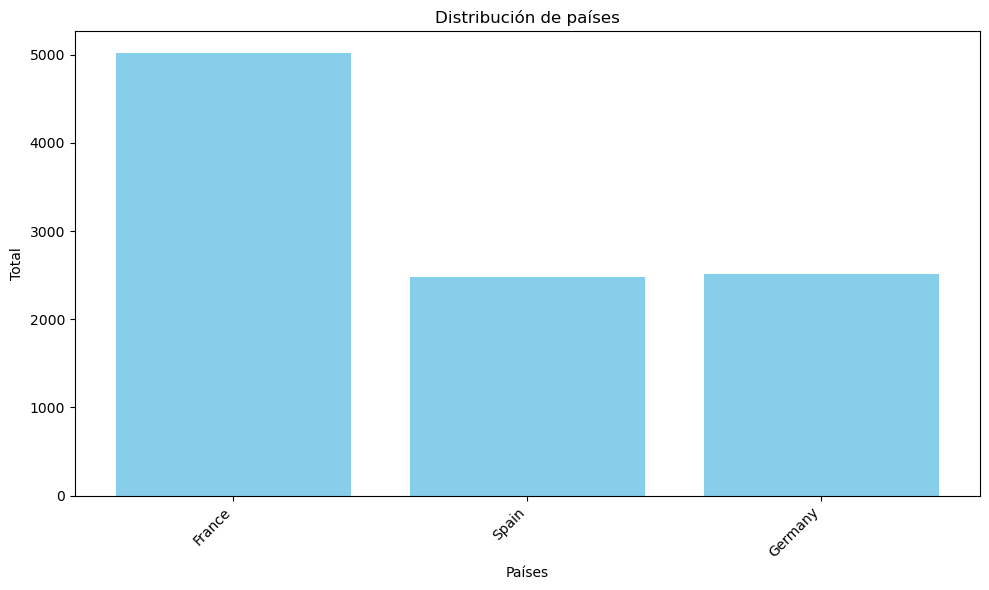

In [5]:
print(f"Geografía: {df['Geography'].values}")
dic_geo = contar_unicos(df,"Geography")
print(dic_geo)
plot_barras_verticales_desde_diccionario(dic_geo,title="Distribución de países",xlabel="Países")

Hay que **recortar valores** de Francia, está bastante sesgado.

Género: ['Female' 'Female' 'Female' ... 'Female' 'Male' 'Female']
{'Female': 4543, 'Male': 5457}


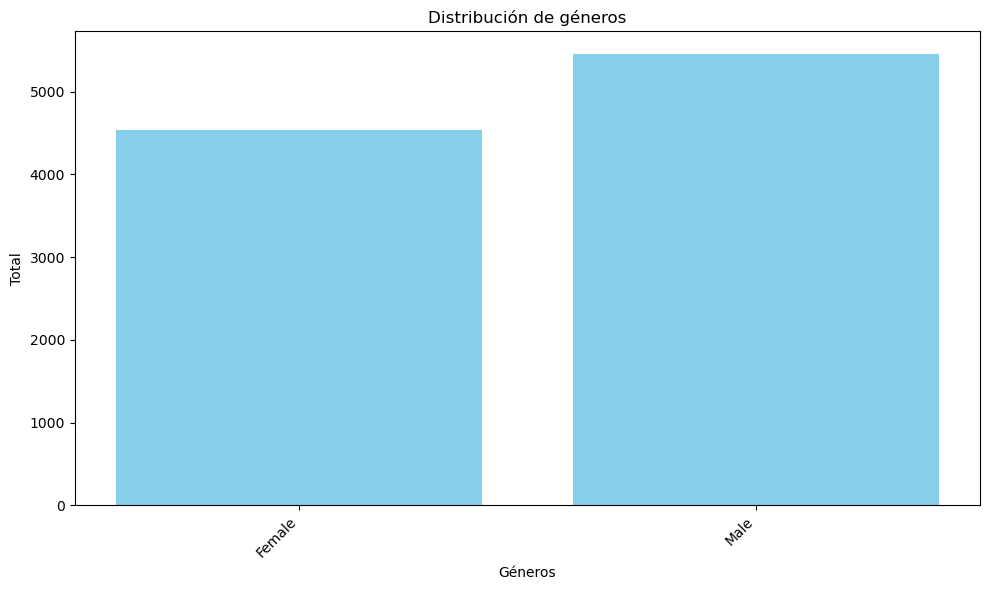

In [6]:
print(f"Género: {df['Gender'].values}")
dic_gen = contar_unicos(df,"Gender")
print(dic_gen)
plot_barras_verticales_desde_diccionario(dic_gen,title="Distribución de géneros",xlabel="Géneros")

Tipo de tarjeta: ['DIAMOND' 'DIAMOND' 'DIAMOND' ... 'SILVER' 'GOLD' 'DIAMOND']
{'DIAMOND': 2507, 'GOLD': 2502, 'SILVER': 2496, 'PLATINUM': 2495}


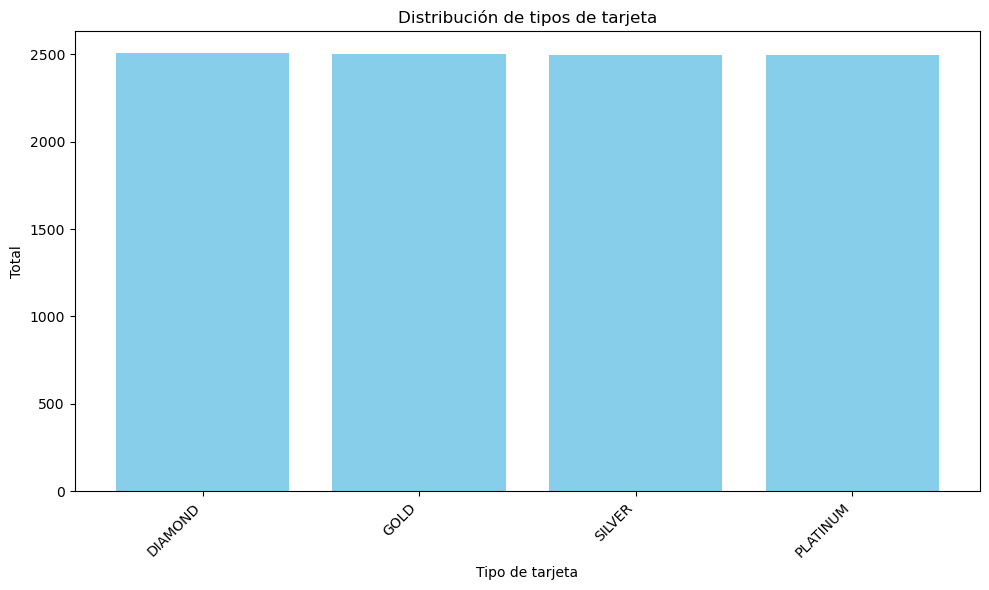

In [7]:
print(f"Tipo de tarjeta: {df['Card Type'].values}")
dic_ct = contar_unicos(df,"Card Type")
print(dic_ct)
plot_barras_verticales_desde_diccionario(dic_ct,title="Distribución de tipos de tarjeta",xlabel="Tipo de tarjeta")

### ¿Hay correlación entre satisfacción y abandono?

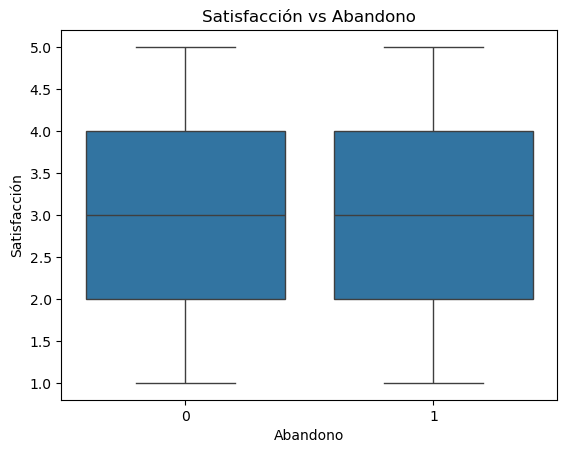

Exited
0    3.017960
1    2.997547
Name: Satisfaction Score, dtype: float64

In [8]:

# Boxplot: distribución de satisfacción según si abandonó o no
sns.boxplot(x='Exited', y='Satisfaction Score', data=df)
plt.title('Satisfacción vs Abandono')
plt.xlabel('Abandono')
plt.ylabel('Satisfacción')
plt.show()


df.groupby('Exited')['Satisfaction Score'].mean()


Parece que la satisfacción por sí sola no predice el abandono. Luego son variables independientes entre si o escasamente relacionadas.

### ¿Los clientes con más productos tienden a quedarse más? 

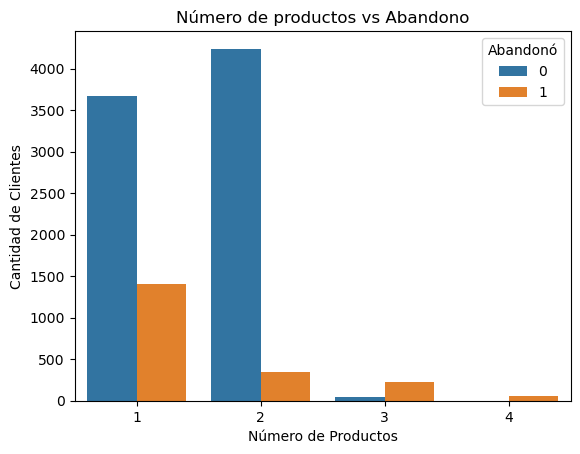

NumOfProducts
1    0.277144
2    0.076035
3    0.827068
4    1.000000
Name: Exited, dtype: float64

In [9]:
sns.countplot(x='NumOfProducts', hue='Exited', data=df)
plt.title('Número de productos vs Abandono')
plt.xlabel('Número de Productos')
plt.ylabel('Cantidad de Clientes')
plt.legend(title='Abandonó')
plt.show()


df.groupby('NumOfProducts')['Exited'].mean()


Parece que abandonan muchos más clientes con pocos productos, esto puede ser un buen indicador del abandono.

### ¿El saldo o ingreso influye en la tasa de abandono? 

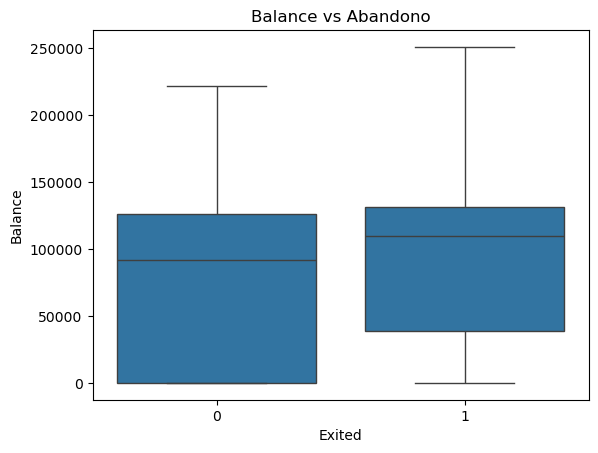

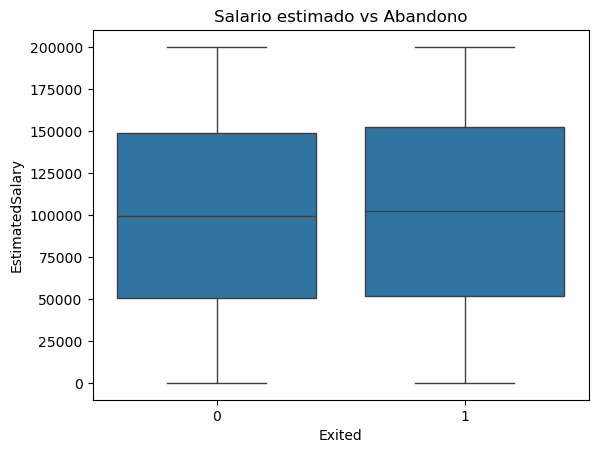

             Balance  EstimatedSalary
Exited                               
0       72742.750663     99726.853141
1       91109.476006    101509.908783

------------------------------------------------------
Correlación:

                    Exited   Balance  EstimatedSalary
Exited           1.000000  0.118577         0.012490
Balance          0.118577  1.000000         0.012797
EstimatedSalary  0.012490  0.012797         1.000000


In [10]:
sns.boxplot(x='Exited', y='Balance', data=df)
plt.title('Balance vs Abandono')
plt.show()

sns.boxplot(x='Exited', y='EstimatedSalary', data=df)
plt.title('Salario estimado vs Abandono')
plt.show()


print(df.groupby('Exited')[['Balance', 'EstimatedSalary']].mean())
print("\n------------------------------------------------------")

print(f"Correlación:\n\n {df[['Exited', 'Balance', 'EstimatedSalary']].corr()}")


El salario no influye en el abandono, sin embargo el saldo parece ir en contra de la lógica, los que más saldo tienen se van, esto puede indicar que buscan mejores oportunidades. Es posible que tenga que ver con las ventajas que ofrecen otros bancos frente al cliente. Puede que al ser personas con más recursos estén más informados, etc... Esto para el punto de vista del banco por sí solo quizá no tenga sentido, pero viéndolo desde el punto de vista del cliente, parece lógico.

De todas formas la correlación es mínima, no parece un indicador fiable por sí solo.

### ¿Las quejas se relacionan directamente con la baja satisfacción o el abandono?

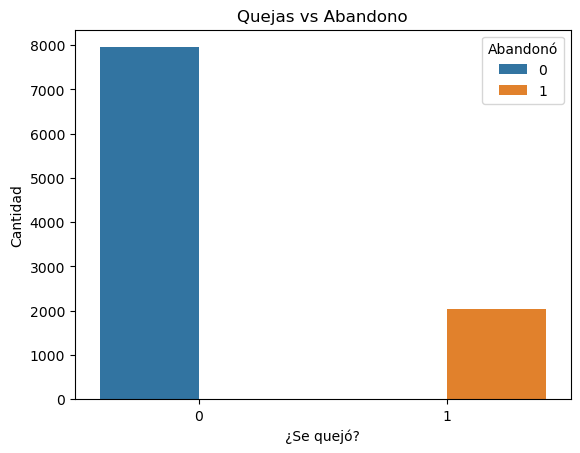

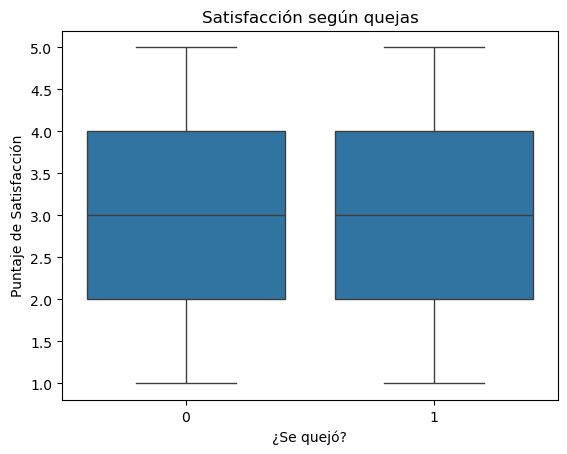

                    Satisfaction Score    Exited  Complain
Satisfaction Score            1.000000 -0.005849 -0.004799
Exited                       -0.005849  1.000000  0.995693
Complain                     -0.004799  0.995693  1.000000


In [11]:
sns.countplot(x='Complain', hue='Exited', data=df)
plt.title('Quejas vs Abandono')
plt.xlabel('¿Se quejó?')
plt.ylabel('Cantidad')
plt.legend(title='Abandonó')
plt.show()

df.groupby('Complain')['Exited'].mean()

sns.boxplot(x='Complain', y='Satisfaction Score', data=df)
plt.title('Satisfacción según quejas')
plt.xlabel('¿Se quejó?')
plt.ylabel('Puntaje de Satisfacción')
plt.show()

df.groupby('Complain')['Satisfaction Score'].mean()

# Corrrelación
cols = ['Satisfaction Score', 'Exited', 'Complain']
corr_matrix = df[cols].corr()
print(corr_matrix)




Tener quejas está muy asociado con el abandono del banco. Pero curiosamente el nivel de quejas no influye en el puntuaje de satisfacción con el banco.

# 2-INGENIERÍA DE CARACTERÍSTICAS

In [12]:
#Copia para no modificar los datos originales
data = df.copy()

In [13]:
#Elimino las columnas innecesarioas
try:
    data.drop(['RowNumber', 'CustomerId', 'Surname', 'Point Earned'], axis=1, inplace=True)
except Exception as e:
    print("No se pudieron eliminar columnas" + e)

In [14]:
#Hay que transformar de categóricas a numéricas

label_encoders = {}

for col in ['Geography', 'Gender', 'Card Type']:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le  



In [15]:
#Escalamos los datos

cols_to_scale = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']
scaler = MinMaxScaler()
data[cols_to_scale] = scaler.fit_transform(data[cols_to_scale])
print(data.head(2))




   CreditScore  Geography  Gender       Age  Tenure   Balance  NumOfProducts  \
0        0.538          0       0  0.324324     0.2  0.000000              1   
1        0.516          2       0  0.310811     0.1  0.334031              1   

   HasCrCard  IsActiveMember  EstimatedSalary  Exited  Complain  \
0          1               1         0.506735       1         1   
1          0               1         0.562709       0         1   

   Satisfaction Score  Card Type  
0                   2          0  
1                   3          0  


# 3-DIVISIÓN DE LOS DATOS

In [16]:
X = data.drop('Exited', axis=1)  # Variables independientes
y = data['Exited']               # Variable objetivo
columnas_modelo = X.columns.tolist()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# 4-MODELO,ENTRENAMIENTO E INFERENCIA

In [17]:
# Creo una red neuronal (RNA) con Keras para realizar la predicción.
input_dim = X_train.shape[1]
model = MiModeloClasificador(input_dim)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = train_model(model, X_train, y_train)


Epoch 1/10


c:\Users\Jorge\anaconda3\envs\llms\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7865 - loss: 0.6380 - val_accuracy: 0.7981 - val_loss: 0.4764
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7916 - loss: 0.4722 - val_accuracy: 0.7981 - val_loss: 0.4047
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7903 - loss: 0.3931 - val_accuracy: 0.8512 - val_loss: 0.3023
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8775 - loss: 0.2839 - val_accuracy: 0.9444 - val_loss: 0.2112
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9582 - loss: 0.2012 - val_accuracy: 0.9881 - val_loss: 0.1431
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9875 - loss: 0.1350 - val_accuracy: 0.9962 - val_loss: 0.0977
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9945 - loss: 0.0898 - val_accuracy: 0.9987 - val_loss: 0.0689
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9978 - loss: 0.0649 - val_accuracy: 0.9987 - val_

# 5-EVALUACIÓN

In [18]:

evaluate_model(model, X_test, y_test)
predict_and_report(model, X_test, y_test)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step - accuracy: 0.9993 - loss: 0.0287
Test accuracy: 0.9990
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
Primeros ejemplos de comparación:
Real: 0, Predicción: 0
Real: 0, Predicción: 0
Real: 0, Predicción: 0
Real: 0, Predicción: 0
Real: 0, Predicción: 0
Real: 0, Predicción: 0
Real: 0, Predicción: 0
Real: 1, Predicción: 1
Real: 0, Predicción: 0
Real: 0, Predicción: 0

Reporte de clasificación completo:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1607
           1       1.00      1.00      1.00       393

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



# 6-EXPOSICIÓN PARA DESPLIEGUE

In [ ]:

from flask import Flask, request, jsonify
import threading

app = Flask(__name__)

@app.route("/")
def home():
    return jsonify({"message": "API funcionando con Flask"})

@app.route("/prediccion", methods=["POST"])
def prediccion():
    try:
        datos = request.get_json()
        prob, pred = predecir_cliente(model, datos, scaler, label_encoders, columnas_modelo)
        return jsonify({
            "probabilidad": round(prob, 4),
            "abandono": int(pred)
        })
    except Exception as e:
        return jsonify({"error": str(e)}), 500

# Ejecutar el servidor Flask en segundo plano
def run_api():
    app.run(port=5000, debug=False, use_reloader=False)

# Inicia el servidor una única vez
threading.Thread(target=run_api).start()


 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
